In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

In [3]:
from mmctools.dataloaders import read_files
from mmctools.helper_functions import covariance

In [4]:
from TTURawToMMC import reg_coefs, tilts
from mmctools.measurements.metmast import tilt_correction

# Process and tilt-correct sonic data from TTU tower
at SWiFT between 2013-11-08 to 09

In [5]:
# DAP data
dataset = 'mmc/tower.z01.00'
datapath = 'data' # where the data will get saved locally
startdate = pd.to_datetime('2013-11-08')
enddate = pd.to_datetime('2013-11-10')

## 1. Data processing

In [6]:
filelist = []
overwrite_files = False # force download of files

### 1a. try to get data from DAP on the fly

In [7]:
try:
    import A2e
except ImportError:
    print('dap-py module not available; need to manually set `filelist`')
else:
    a2e = A2e.A2e()
    a2e.setup_cert_auth()
    datafiles = a2e.search({
        'Dataset': dataset,
        'date_time': {
            'between': [startdate.strftime('%Y%m%d%H%M%S'), enddate.strftime('%Y%m%d%H%M%S')]
        }
    })
    print(len(datafiles),'data files selected')
    filelist = a2e.download_files(datafiles, path=datapath, force=overwrite_files)
    if filelist is None:
        print('No files were downloaded; need to manually download and set `filelist`')

Certificate is setup
Valid certificate already created
48 data files selected
Could not place order
Server Returned Bad Status Code
Status Code: 400
Reason: Bad Request
No files were downloaded; need to manually download and set `filelist`


In [8]:
# UNCOMMENT THIS to use previously downloaded files
import glob
filelist = glob.glob('data/mmc.tower.z01.00/*.dat')
filelist.sort()
filelist

['data/mmc.tower.z01.00/tower.z01.00.20131108.000000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.010000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.020000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.030000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.040000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.050000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.060000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.070000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.080000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.090000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.100000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.110000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.120000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.130000.ttu200m.dat',
 'data/mmc.tower.z01.00/tower.z01.00.20131108.140000.ttu200m.d

### 1b. process downloaded data

In [9]:
variables = ['unorth','vwest','w','ustream','vcross','wdir','tsonic','t','p','rh']

#heights_ft = [3,8,13,33,55,155,245,382,519,656]
heights = np.array([0.9, 2.4, 4.0, 10.1, 16.8, 47.3, 74.7, 116.5, 158.2, 200.0])
sampling_freq = 50. # Hz
resample_interval = '1s'

In [10]:
# *wide* format: variables change the fastest, then heights
# e.g., unorth_3ft, vwest_3ft, ..., rh_3ft, unorth_8ft, vwest_8ft, ...
columns = pd.MultiIndex.from_product([heights,variables],names=['height',None])

In [11]:
def read_wide_csv(fname,**kwargs):
    """Convert table in wide format into stacked/long format with multiindex
    If 'reindex' is True, then reindex the resulting dataframe to conform to 
    a DateTimeIndex with regular intervals as dictated by 'sampling_freq'.
    """
    df = pd.read_csv(fname,
                     skiprows=5, header=None,
                     index_col=0, parse_dates=True,
                     **kwargs)
    df.index.name = 'datetime'
    df.columns = columns
    df = df.resample(resample_interval).first()
    return df.stack(level=0)

In [12]:
%time rawdata = read_files(filelist, reader=read_wide_csv)
rawdata.head()

CPU times: user 3min 45s, sys: 10.4 s, total: 3min 55s
Wall time: 3min 10s


p      rh        t    tsonic    unorth   ustream  \
datetime   height                                                             
2013-11-08 0.9     90.854775  26.186  52.9592  61.26800 -2.638194  2.640161   
           2.4     90.872351  25.810  53.2076  64.09399 -2.796803  2.833327   
           4.0     90.821555  25.380  53.6288  57.86600 -4.041865  4.005252   
           10.1    90.761141  25.264  53.8664  57.38000 -5.229591  5.225090   
           16.8    90.730765  24.934  54.0752  58.02800 -5.908238  5.901349   

                     vcross     vwest         w        wdir  
datetime   height                                            
2013-11-08 0.9    -0.093404 -0.138231  0.040203  177.000664  
           2.4     0.393956 -0.600695  0.297950  167.878211  
           4.0    -0.683208  0.414897  0.342024  185.860873  
           10.1   -0.351743 -0.276876 -0.354408  176.969358  
           16.8   -0.287311  0.034531 -0.112876  180.334863

<font color='red'>tower.z01.00 conversions</font>

In [13]:
rawdata['u'] = rawdata['vwest']
rawdata['v'] = -rawdata['unorth']
#rawdata['wspd'] = np.sqrt(rawdata['u']**2 + rawdata['v']**2)

In [14]:
# convert from deg F to K
rawdata['t'] = 5./9. * (rawdata['t']-32) + 273.15
rawdata['ts'] = 5./9. * (rawdata['tsonic']-32) + 273.15

In [15]:
# convert kPa to mbar
rawdata['p'] *= 10.

## 2. Calculations
### 2a. Tilt correction

In [16]:
df = rawdata[['u','v','w','t','ts','p']].unstack() # make an unstacked copy

In [17]:
ucorr,vcorr,wcorr = tilt_correction(df['u'],df['v'],df['w'],
                                    reg_coefs=reg_coefs,
                                    tilts=tilts)

In [18]:
df.loc[:,'u'] = ucorr
df.loc[:,'v'] = vcorr
df.loc[:,'w'] = wcorr

In [19]:
%time df.stack(dropna=False).to_csv('data/TTU_tilt_corrected_20131108-09.csv')

CPU times: user 29.6 s, sys: 1.08 s, total: 30.7 s
Wall time: 29.7 s


### 2b. Statistics

In [20]:
def calc_stats(unstacked,offset):
    """Calculate statistics with specified pandas offset"""
    df = unstacked.rolling(offset).mean().stack()
    # TODO: general MMC calculations here
    df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)
    # - recalculate wind direction
    newdir = np.degrees(np.arctan2(-df['u'],-df['v']))
    newdir[newdir < 0] += 360.0
    df['wdir'] = newdir
    # - calculate potential temperature
    df['theta'] = df['t'] * (1000./df['p'])**0.286
    # - calculate variances
    df['uu'] = unstacked['u'].rolling(offset).var().stack()
    df['vv'] = unstacked['v'].rolling(offset).var().stack()
    df['ww'] = unstacked['w'].rolling(offset).var().stack()
    # - calculate covariances
    df['uv'] = covariance(unstacked[('u',)], unstacked[('v',)], offset).stack()
    df['vw'] = covariance(unstacked[('v',)], unstacked[('w',)], offset).stack()
    df['uw'] = covariance(unstacked[('u',)], unstacked[('w',)], offset).stack()
    df['tw'] = covariance(unstacked[('ts',)], unstacked[('w',)], offset).stack()
    # - calculate derived quantities
    df['u*'] = (df['uw']**2 + df['vw']**2)**0.25
    df['TKE'] = 0.5*(df['uu'] + df['vv'] + df['ww'])
    ang = np.radians(270. - df['wdir'])
    ang[ang<0] += 2*np.pi
    df['TI'] = df['uu']*np.cos(ang)**2 + 2*df['uv']*np.sin(ang)*np.cos(ang) + df['vv']**np.sin(ang)**2
    df['TI'] = np.sqrt(df['TI']) / df['wspd']
    return df

In [21]:
%time uncorrected = calc_stats(rawdata.unstack(),'10min')

CPU times: user 43.1 s, sys: 4.93 s, total: 48 s
Wall time: 27.1 s


In [22]:
%time stats = calc_stats(df,'10min')

CPU times: user 37.6 s, sys: 4.73 s, total: 42.3 s
Wall time: 24.8 s


## 3. Plots
TODO: implement `mmctools.plotting`

In [23]:
times = stats.index.levels[0]

Text(0.5, 0, 'UTC')

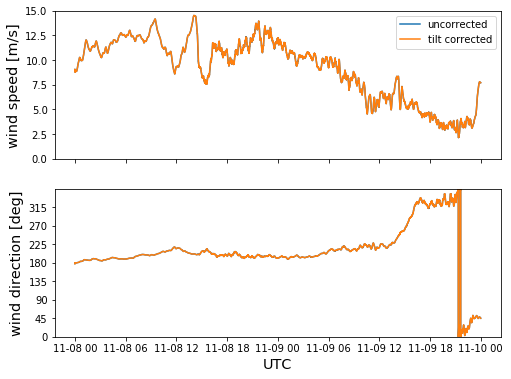

In [24]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(8,6))
ax[0].plot(times, uncorrected.xs(74.7,level=1)['wspd'], label='uncorrected')
ax[0].plot(times, stats.xs(74.7,level=1)['wspd'], label='tilt corrected')
ax[0].set_ylim((0,15))
ax[1].plot(times, uncorrected.xs(74.7,level=1)['wdir'], label='uncorrected')
ax[1].plot(times, stats.xs(74.7,level=1)['wdir'], label='tilt corrected')
ax[1].set_ylim((0,360))
ax[1].set_yticks(np.arange(0,360,45))
ax[0].legend(loc='best')
ax[0].set_ylabel('wind speed [m/s]',fontsize='x-large')
ax[1].set_ylabel('wind direction [deg]',fontsize='x-large')
ax[1].set_xlabel('UTC',fontsize='x-large')

Text(0.5, 0, 'UTC')

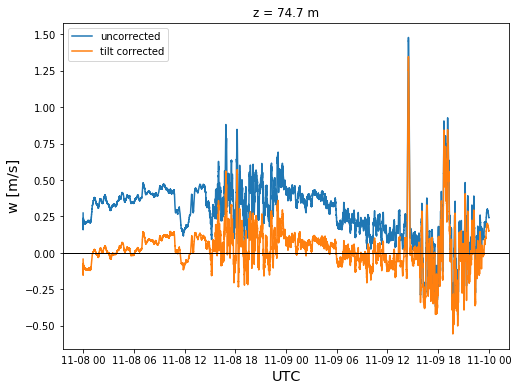

In [25]:
z = 74.7
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(times, uncorrected.xs(z,level=1)['w'], label='uncorrected')
ax.plot(times, stats.xs(z,level=1)['w'], label='tilt corrected')
ax.axhline(0,color='k',lw=1)
ax.legend(loc='best')
ax.set_title('z = {:.1f} m'.format(z))
ax.set_ylabel(r'w [m/s]',fontsize='x-large')
ax.set_xlabel('UTC',fontsize='x-large')

Text(0.5, 0, '$time$ $[\\mathrm{HH:MM}]$ $Z$')

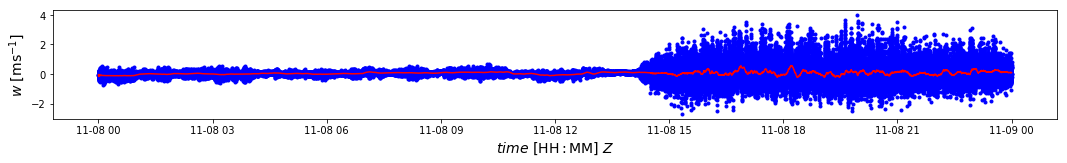

In [26]:
# Jeremy's plot from `TTU_tiltCorrection.ipynb`
sonicLevel=6
w = df['w'][heights[sonicLevel]]
day1 = (w.index >= '2013-11-08 00:00') & (w.index <= '2013-11-09 00:00')
w = w.loc[day1]
wmean = w.rolling('10min').mean()
fig,axs = plt.subplots(1,1,figsize=(18,2))
axs.plot(w.index, w, 'b.')
axs.plot(wmean.index, wmean, 'r-')
axs.set_ylabel(r'$w$ $[\mathrm{ms^{-1}}]$',fontsize=14)
axs.set_xlabel(r'$time$ $[\mathrm{HH:MM}]$ $Z$',fontsize=14)

Text(0.5, 0, 'UTC')

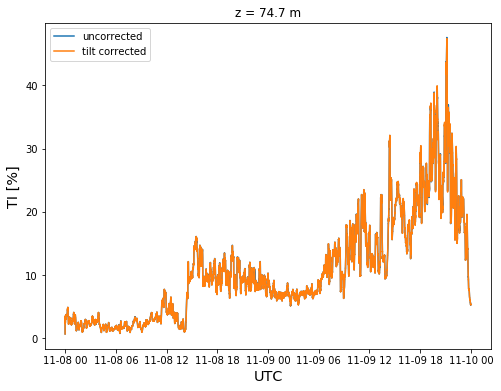

In [27]:
z = 74.7
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(times, 100*uncorrected.xs(z,level=1)['TI'], label='uncorrected')
ax.plot(times, 100*stats.xs(z,level=1)['TI'], label='tilt corrected')
ax.legend(loc='best')
ax.set_title('z = {:.1f} m'.format(z))
ax.set_ylabel('TI [%]',fontsize='x-large')
ax.set_xlabel('UTC',fontsize='x-large')

Text(0.5, 0, 'UTC')

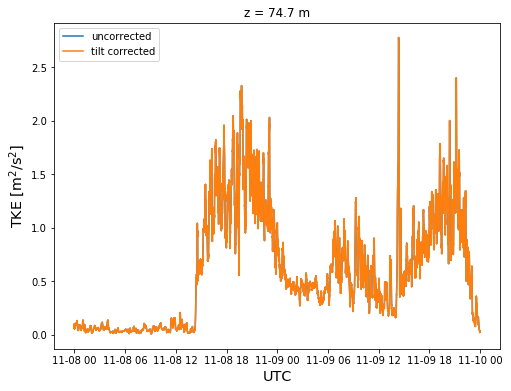

In [28]:
z = 74.7
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(times, uncorrected.xs(z,level=1)['TKE'], label='uncorrected')
ax.plot(times, stats.xs(z,level=1)['TKE'], label='tilt corrected')
ax.legend(loc='best')
ax.set_title('z = {:.1f} m'.format(z))
ax.set_ylabel(r'TKE [m$^2$/s$^2$]',fontsize='x-large')
ax.set_xlabel('UTC',fontsize='x-large')

Text(0.5, 0, 'UTC')

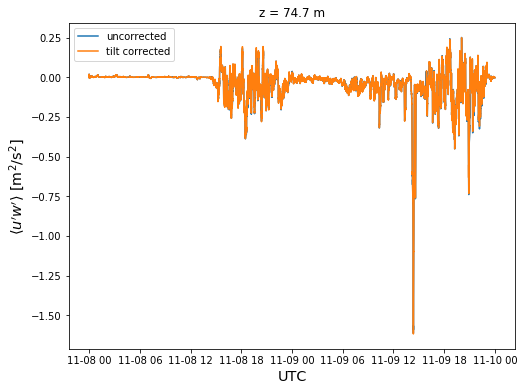

In [29]:
z = 74.7
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(times, uncorrected.xs(z,level=1)['uw'], label='uncorrected')
ax.plot(times, stats.xs(z,level=1)['uw'], label='tilt corrected')
ax.legend(loc='best')
ax.set_title('z = {:.1f} m'.format(z))
ax.set_ylabel(r"$\langle u' w' \rangle$ [m$^2$/s$^2$]",fontsize='x-large')
ax.set_xlabel('UTC',fontsize='x-large')

(-0.5, 0.5)

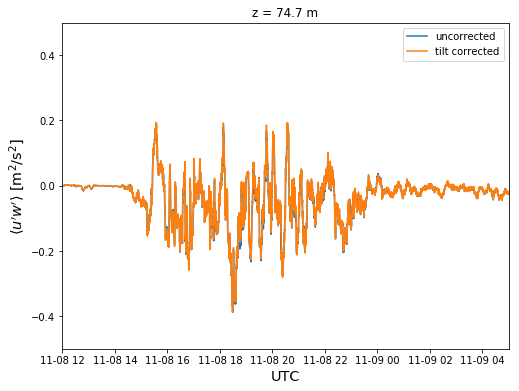

In [30]:
z = 74.7
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(times, uncorrected.xs(z,level=1)['uw'], label='uncorrected')
ax.plot(times, stats.xs(z,level=1)['uw'], label='tilt corrected')
ax.legend(loc='best')
ax.set_title('z = {:.1f} m'.format(z))
ax.set_ylabel(r"$\langle u' w' \rangle$ [m$^2$/s$^2$]",fontsize='x-large')
ax.set_xlabel('UTC',fontsize='x-large')
ax.set_xlim(('2013-11-08 12:00','2013-11-09 05:00'))
ax.set_ylim((-0.5,0.5))

(-0.9, 0.1)

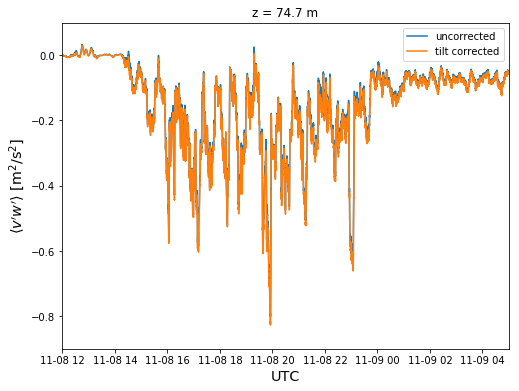

In [31]:
z = 74.7
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(times, uncorrected.xs(z,level=1)['vw'], label='uncorrected')
ax.plot(times, stats.xs(z,level=1)['vw'], label='tilt corrected')
ax.legend(loc='best')
ax.set_title('z = {:.1f} m'.format(z))
ax.set_ylabel(r"$\langle v' w' \rangle$ [m$^2$/s$^2$]",fontsize='x-large')
ax.set_xlabel('UTC',fontsize='x-large')
ax.set_xlim(('2013-11-08 12:00','2013-11-09 05:00'))
ax.set_ylim((-0.9,0.1))

(-0.3, 0.3)

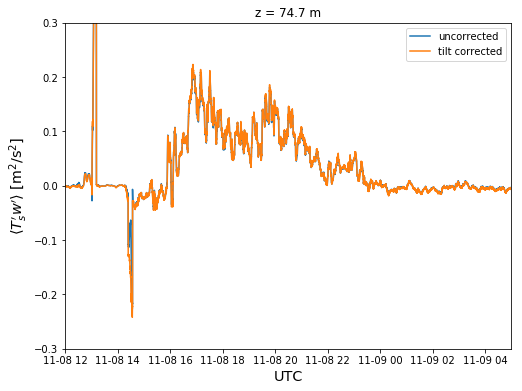

In [32]:
z = 74.7
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(times, uncorrected.xs(z,level=1)['tw'], label='uncorrected')
ax.plot(times, stats.xs(z,level=1)['tw'], label='tilt corrected')
ax.legend(loc='best')
ax.set_title('z = {:.1f} m'.format(z))
ax.set_ylabel(r"$\langle T_s' w' \rangle$ [m$^2$/s$^2$]",fontsize='x-large')
ax.set_xlabel('UTC',fontsize='x-large')
ax.set_xlim(('2013-11-08 12:00','2013-11-09 05:00'))
ax.set_ylim((-0.3,0.3))